# Optimization: strategies with decreasing information from the objective

We consider the unconstrained minimization problem $$\min_{x\in \mathbb{R}^n} f(x),$$ with $f\in C^2$.  From Prof. Stadler's notes we saw the main outline of the descent algorithm:

1. Have an initial guess $x_k$ of a minimizer.

2. Compute the gradient $g_k = \nabla f(x_k)\in L(\mathbb{R}^n,\mathbb{R})\sim \mathbb{R}^n.$ 

[We call $L(V,\mathbb{R})$ the *algebraic dual space* of $V$, $V^*$.

Like all linear operators, if its operator norm is finite, $g(x) \in B(V,\mathbb{R})$, which we call the *continuous dual space* $V'$.

We already know that if $V$ is finite dimensional, then $B(V,\mathbb{R}) = L(V,\mathbb{R})$.

We also know that for $V = \mathbb{R}^n$, a space of column vectors, that turning a vector on its side, making a row vector, makes something that, when operating on a column vector returns a number. That is $x^T y$ is a number.

In fact, *any* linear functional from $\mathbb{R}^n$ into $\mathbb{R}$ is represent by a row vector.  Thus $(\mathbb{R}^n)' \sim \mathbb{R}^n$.  This generalizes to one particular version of infinite dimensional normed vector space: the [Hilbert Space](https://en.wikipedia.org/wiki/Hilbert_space).  A Hilbert space is an inner product space that is complete, and has the following property:

Let $V$ be a hilbert space, and let $f$ be a functional in $V'$.  Then there exists a unique $x_g\in V$ such that

$$ g[y] = (x,y)_H\quad\forall y \in V,$$

and therefore $V' \sim V$.

This is known as the [Riesz representation theorem](https://en.wikipedia.org/wiki/Riesz_representation_theorem),
and $x_f$ is the Riesz representer of $f$.  In $\mathbb{R}^n$, $x$ is the Riesz representer of $x^T$.

Suppose we define the inner product of a finite dimensional space $H$ by $(x,y)_V := x^T M y$, where $M$ is symmetric positive definite.  $g[y]:y\mapsto z^T y$ is a valid functional.  What is its Riesz representer in $V$?
It isn't $z$, because $(z,y)_V = z^T M y \neq f(y)$.  Instead it is $\tilde{z} = M^{-1} z$:

$$ (\tilde{z},y)_H = z^T M^{-1} M y = g[y].$$

Why am I going into this detail?  In some applications, we may have a closed form expression for the gradient, but if we're not careful about whether we have derived $g$ or its Riesz representer, we can compute the wrong descent direction.]

3. Compute a search direction $d \in V$ such that $(-g_k)^T d >= 0$.  We do this by solving $$B_k d = -g_k,$$
for some s.p.d. matrix $B_k.$  Near the true solution, we will get fast convergence if we use the *Hessian* for $B_k$:

$$H_k = \nabla^2 f(x_k) \in L(\mathbb{R}^n,\mathbb{R}^n) \sim \mathbb{R}^{n \times n}.$$

[When working in a Hilbert space, by definition $H_k \in L(V, V^*)$, or if all quantities are bounded and continuous, $H_k \in B(V, V')$.]

4. Compute an update $x_{k + 1} = x_k + \alpha d$, where the *step length* alpha is chosen to guarantee sufficient decrease in the objective by a line search procedure.

## Example

In [2]:
from scipy.optimize import minimize
from numpy.random import randn
from numpy import log2
import fenics as fe
from fenics_adjoint import *
from scipy.linalg import inv, norm

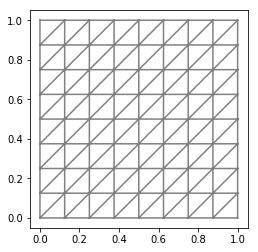

In [3]:
%matplotlib inline
n_mesh = 8
alpha = 1.
beta = 1. / (n_mesh * n_mesh)

mesh = fe.UnitSquareMesh(n_mesh,n_mesh)
fe.plot(mesh)

In [4]:
M = fe.FunctionSpace(mesh,'DG',0)
V = fe.FunctionSpace(mesh,'CG',1)
D = fe.FunctionSpace(mesh,'DG',1)

m_dim = M.dim()
v_dim = V.dim()
d_dim = D.dim()
print((m_dim,v_dim,d_dim))

(128, 81, 384)


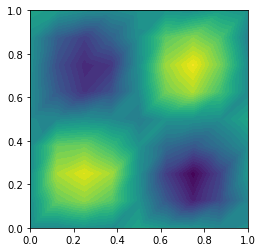

In [5]:
from numpy.random import randn

d_exp = Expression('0.1 * sin(2 * pi * x[0]) * sin(2 * pi * x[1])', degree = 1)
d = interpolate(d_exp,D)
d.vector()[:] += 0.01 * randn(d_dim)
fe.plot(d)

In [6]:
def b(u):
    return assemble(0.5 * (u - d) * (u - d) * fe.dx)

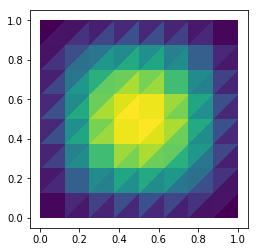

In [7]:
m_0 = interpolate(Expression('sin(pi * x[0]) * sin(pi * x[1])', degree = 1),M)
m_0_array = m_0.vector()[:]
fe.plot(m_0)

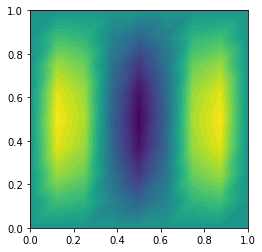

In [8]:
rhs_exp = Expression('sin(3 * pi * x[0]) * sin(pi * x[1])',degree = 1)
rhs = interpolate(rhs_exp,V)

fe.plot(rhs)

In [9]:
def u(m):
    v = fe.TestFunction(V)
    u_sol = Function(V)
    A = (fe.inner(fe.grad(v),fe.exp(m) * fe.grad(u_sol)) + beta * u_sol * v - v * rhs)* fe.dx
    solve(A == 0, u_sol)
    return u_sol

In [10]:
def reg(m):
    return assemble(alpha * 0.5 * (m * m) * fe.dx)

In [11]:
def misfit(m):
    return b(u(m))

In [12]:
def f(m_array):
    m = Function(M)
    m.vector().set_local(m_array)
    return misfit(m) + reg(m)

def f_func(m):
    return misfit(m) + reg(m)

f_value = f_func(m_0)
print(type(f_value))

<class 'pyadjoint.adjfloat.AdjFloat'>


In [13]:
J_hat = ReducedFunctional(f_value,Control(m_0))

In [15]:
print(type(J_hat))
J_hat(m_0)

<class 'pyadjoint.reduced_functional.ReducedFunctional'>


28.42886913735797

In [16]:
tape = J_hat.tape
print(type(tape))

<class 'pyadjoint.tape.Tape'>


In [17]:
tape.visualise()

Run the command line:
--> tensorboard --logdir=log
Then open http://localhost:6006/ in your web browser.


In [ ]:
def reg_m(m):
    m_hat = TrialFunction(M)
    grad = assemble(alpha * (m * m_hat) * dx)
    return grad

reg_m(m_0)[:]

In [ ]:
def b_u(u):
    u_hat = TrialFunction(V)
    grad = assemble((u - d) * u_hat * dx)
    return grad
    
b_u(u_0)[:]

In [ ]:
def u_m(m,u_sol=None):
    v = TestFunction(V)
    u_hat = TrialFunction(V)
    m_hat = TrialFunction(M)
    if not u_sol:
        u_sol = u(m)
    A_m = assemble((inner(grad(v),exp(m) * m_hat * grad(u_sol)))* dx).array()
    A_u = assemble((inner(grad(v),exp(m) * grad(u_hat)) + beta * u_hat * v) * dx).array()
    return inv(A_u).dot(-A_m)

u_m(m_0,u_sol = u_0)

In [ ]:
def f_m_direct(m_array):
    m = Function(M)
    m.vector().set_local(m_array)
    u_sol = u(m)
    u_sol_m = u_m(m, u_sol = u_sol)
    b_u_sol = b_u(u_sol)
    b_m = b_u_sol[:].dot(u_sol_m)
    return b_m + reg_m(m)[:]
    
f_m_0_direct = f_m_direct(m_0_array)

In [ ]:
def u_m_T_dot(m, r, u_sol = None, v = None):
    v_tilde = TrialFunction(V)
    u_hat = TestFunction(V)
    m_hat = TestFunction(M)
    if not u_sol:
        u_sol = u_m(m)
    A_u_T = assemble((inner(grad(v_tilde),exp(m) * grad(u_hat)) + beta * u_hat * v_tilde) * dx)
    if not v:
        v = Function(V)
    solve(A_u_T,v.vector(),r)
    return assemble(-(inner(grad(v),exp(m) * m_hat * grad(u_sol)))* dx)
    
def f_m_adjoint(m_array):
    m = Function(M)
    m.vector().set_local(m_array)
    u_sol = u(m)
    return u_m_T_dot(m, b_u(u_sol), u_sol = u_sol)[:] + reg_m(m)[:]

f_m_0_adjoint = f_m_adjoint(m_0_array)
print(norm(f_m_0_direct - f_m_0_adjoint))

In [ ]:
def taylor_test(F, F_x, x, e_min, e_max, step=0.5):
    x.shape[0]
    y = randn(x.shape[0])
    F_e = F_x(x).dot(y)
    e = e_max
    F_0 = F(x)
    es = []
    diffs = []
    
    while e > e_min:
        z = x + e * y
        F_z = F(z)
        F_z_affine = F_0 + e * F_e
        diff = norm(F_z - F_z_affine)
        es.append(e)
        diffs.append(diff)
        print(e,diff)
        e *= step
    t_n = len(es)
    return (log2(diffs[0:(t_n-1)]) - log2(diffs[1:t_n])) / (log2(es[0:(t_n-1)]) - log2(es[1:t_n]))

taylor_test(f, f_m_adjoint, m_0_array, 1.e-6, 1.e0)

In [ ]:
def reg_mm(m):
    m_hat = TestFunction(M)
    m_tilde = TrialFunction(M)
    return assemble(alpha * m_hat * m_tilde * dx)

def reg_mm_dot(m, m_tilde):
    m_hat = TestFunction(M)
    return assemble(alpha * m_hat * m_tilde * dx)

reg_mm(m_0).array()

In [ ]:
def b_uu(u):
    u_hat = TestFunction(V)
    u_tilde = TrialFunction(V)
    return assemble(u_hat * u_tilde * dx)

def b_uu_dot(u, u_tilde):
    u_hat = TestFunction(V)
    return assemble(u_hat * u_tilde * dx)

def b_u_array(u_array):
    u = Function(V)
    u.vector().set_local(u_array)
    return b_u(u)[:]

def b_uu_array(u_array):
    u = Function(V)
    u.vector().set_local(u_array)
    return b_uu(u).array()

b_uu(u_0).array()

taylor_test(b_u_array, b_uu_array, u_0.vector()[:], 1.e-6, 1.e0)

In [ ]:
def b_u_dot_u_mm(m, u_sol = None, u_m_sol = None, b_u_sol = None, v = None):
    if not u_sol:
        u_sol = u(m)
    if not u_m_sol:
        u_m_sol = u_m(m, u_sol = u_sol)
    if not b_u_sol:
        b_u_sol = b_u(u_sol)
    if not v:
        v = Function(V)
        f_m = u_m_T_dot(m, b_u_sol, u_sol = u_sol, v = v)
    u_hat = TestFunction(V)
    m_hat = TestFunction(M)
    m_tilde = TrialFunction(M)
    # vA_uu = 0 !
    vA_um = assemble(inner(grad(v),exp(m) * m_tilde * grad(u_hat)) * dx).array()
    vA_mm = assemble(inner(grad(v),exp(m) * m_hat * m_tilde * grad(u_sol)) * dx).array()
    return -(vA_mm + u_m_sol.T.dot(vA_um) + vA_um.T.dot(u_m_sol))
    
b_u_dot_u_mm(m_0, u_sol = u_0)

In [ ]:
def f_mm_direct(m_array, u_sol = None, u_m_sol = None, v = None):
    m = Function(M)
    m.vector().set_local(m_array)
    if not u_sol:
        u_sol = u(m)
    b_u_sol = b_u(u_sol)
    if not u_m_sol:
        u_m_sol = u_m(m, u_sol = u_sol)
    if not v:
        v = Function(V)
        _ = u_m_T_dot(m, b_u_sol, u_sol = u_sol, v = v)
    b_uu_sol = b_uu(u_sol).array()
    b_u_dot_u_mm_sol = b_u_dot_u_mm(m, u_sol = u_sol, b_u_sol = b_u_sol, v = v)
    return (reg_mm(m).array() + u_m_sol.T.dot(b_uu_sol.dot(u_m_sol)) + b_u_dot_u_mm_sol)

f_mm_direct(m_0_array)

taylor_test(f_m_adjoint, f_mm_direct, m_0_array, 1.e-6, 1.)